In [22]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr  
import datetime
import seaborn as sns
import numpy as np

In [7]:
df = pd.read_excel("SP500_data.xlsx", parse_dates=True, index_col= 0)

In [8]:
print(df)

            SP500_Close        VIX  DGS10        Oil         Gold
Date                                                             
2001-01-02  1283.270020  29.990000   5.11  27.200001   268.399994
2001-01-03  1347.560059  26.600000   4.92  27.950001   268.000000
2001-01-04  1333.339966  26.969999   5.14  28.200001   267.299988
2001-01-05  1298.349976  28.670000   5.03  28.000000   268.000000
2001-01-08  1295.859985  29.840000   4.93  27.350000   268.000000
...                 ...        ...    ...        ...          ...
2024-12-23  5974.069824  16.780001   4.31  70.599998  2617.199951
2024-12-24  6040.040039  14.270000   4.27  70.599998  2617.199951
2024-12-26  6037.589844  14.730000   4.24  70.599998  2617.199951
2024-12-27  5970.839844  15.950000   4.30  70.599998  2617.199951
2024-12-30  5906.939941  17.400000   5.11  70.599998  2617.199951

[6036 rows x 5 columns]


In [9]:
print(df.head())

            SP500_Close        VIX  DGS10        Oil        Gold
Date                                                            
2001-01-02  1283.270020  29.990000   5.11  27.200001  268.399994
2001-01-03  1347.560059  26.600000   4.92  27.950001  268.000000
2001-01-04  1333.339966  26.969999   5.14  28.200001  267.299988
2001-01-05  1298.349976  28.670000   5.03  28.000000  268.000000
2001-01-08  1295.859985  29.840000   4.93  27.350000  268.000000


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6036 entries, 2001-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SP500_Close  6036 non-null   float64
 1   VIX          6036 non-null   float64
 2   DGS10        6036 non-null   float64
 3   Oil          6036 non-null   float64
 4   Gold         6036 non-null   float64
dtypes: float64(5)
memory usage: 282.9 KB
None


In [12]:
print(df.describe())

       SP500_Close          VIX        DGS10          Oil         Gold
count  6036.000000  6036.000000  6036.000000  6036.000000  6036.000000
mean   2139.979443    19.729506     3.211186    65.146148  1176.800911
std    1260.073035     8.581434     1.243155    24.916403   578.423760
min     676.530029     9.140000     0.520000   -37.630001   255.100006
25%    1191.377502    13.740000     2.180000    46.349998   650.599976
50%    1525.585022    17.520000     3.150000    64.389999  1240.049988
75%    2798.095032    23.030001     4.260000    83.145000  1628.975006
max    6090.270020    82.690002     5.540000   145.289993  2788.500000


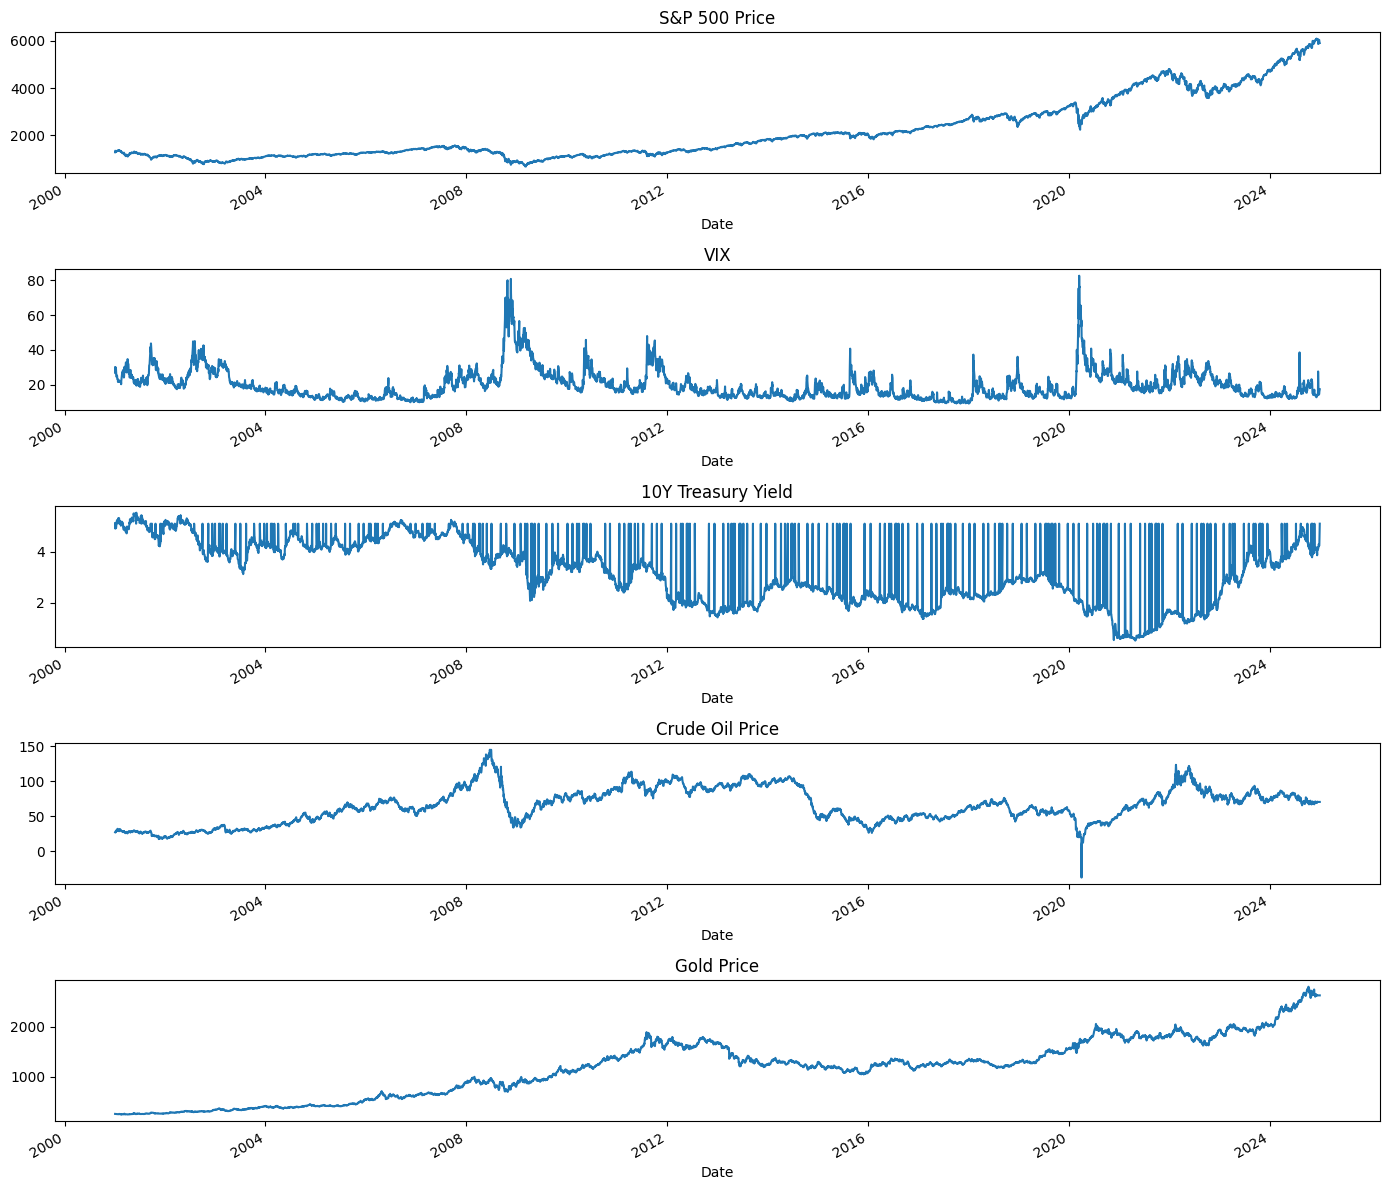

In [15]:

fig, axes = plt.subplots(5, 1, figsize=(14, 12))
df['SP500_Close'].plot(ax=axes[0], title='S&P 500 Price')
df['VIX'].plot(ax=axes[1], title='VIX')
df['DGS10'].plot(ax=axes[2], title='10Y Treasury Yield')
df['Oil'].plot(ax=axes[3], title='Crude Oil Price')
df['Gold'].plot(ax=axes[4], title='Gold Price')
plt.tight_layout()

Text(0.5, 1.0, 'Feature Correlations')

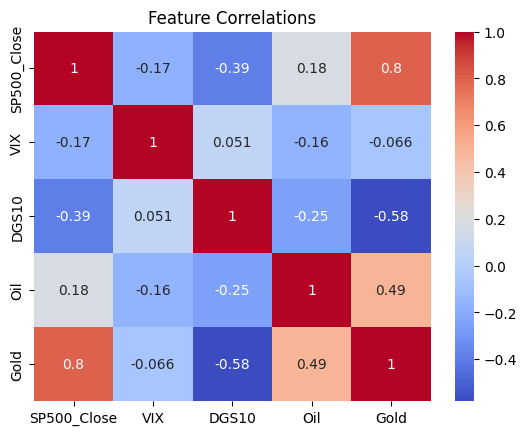

In [18]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlations")

In [20]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Stat: {result[0]:.3f}, p-value: {result[1]:.3f}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")

print("\nStationarity Tests:")
check_stationarity(df['SP500_Close'])  # Likely non-stationary (price)
check_stationarity(df['DGS10'])        # Possibly stationary
check_stationarity(df['VIX'])          # Likely stationary
check_stationarity(df['Gold'])
check_stationarity(df['Oil'])


Stationarity Tests:
ADF Stat: 2.659, p-value: 0.999
Non-Stationary
ADF Stat: -2.092, p-value: 0.248
Non-Stationary
ADF Stat: -5.884, p-value: 0.000
Stationary
ADF Stat: 0.264, p-value: 0.976
Non-Stationary
ADF Stat: -2.858, p-value: 0.050
Non-Stationary


In [23]:
df['SP500_Returns'] = np.log(df['SP500_Close'] / df['SP500_Close'].shift(1))
check_stationarity(df['SP500_Returns'].dropna())

ADF Stat: -19.338, p-value: 0.000
Stationary


In [24]:
df['DGS10_diff'] = df['DGS10'].diff().dropna()
check_stationarity(df['DGS10_diff'])

ADF Stat: -16.676, p-value: 0.000
Stationary


In [25]:
df['Oil_Returns'] = np.log(df['Oil'] / df['Oil'].shift(1))
check_stationarity(df['Oil_Returns'].dropna())

/Users/muhammadshahzebali/ali/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ADF Stat: -13.980, p-value: 0.000
Stationary


In [26]:
df['Gold_Returns'] = np.log(df['Gold'] / df['Gold'].shift(1))
check_stationarity(df['Gold_Returns'].dropna())

ADF Stat: -24.933, p-value: 0.000
Stationary
